In [ ]:
!pip install --upgrade pip
!pip install --upgrade keras
!pip install -U -q tensorflow
#!pip show keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [ ]:
# Nämä importattiin simple audio mallissa.
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from scipy.ndimage import convolve
from keras import layers
from keras import models
from IPython import display



In [ ]:
import sys

import numpy as np
from keras import Model
from keras import Layer

def import_model(filepath: str) -> Model:
    """Load model from file"""
    model: Model = models.load_model(filepath)
    return model

model = import_model('model_export.keras')
print(model.summary())



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,876,829 (18.60 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 3,251,218 (12.40 MB)

None


In [ ]:
def get_layer_weights(layer: str, model: Model) -> list[np.ndarray]:
    """Get layer weights from given model"""
    return model.get_layer(layer).get_weights()


def get_weights_shape(layer: list[np.ndarray]):
    tmp = []
    for i in layer:
        tmp.append(i.shape)
    return tmp



class DummyLayer(Layer):
    def __init__(self):
        super(DummyLayer, self).__init__()

    def call(self, inputs):
        return inputs

def get_reference_layer(layer: str, model: Model):
    """Split the model in to three parts start, layer and rest.

    Example:
    ```python
    model = import_model("../model/test_model.keras")
    (start, layer, end) = get_reference_layer("dense", model)

    result = start(waveform)
    layer_result = layer(result)
    print(layer_result)
    ```
    """
    modelStart = models.Sequential()
    selectedLayer: Layer
    modelEnd = models.Sequential()

    start = True
    l: Layer
    for l in model.layers:
        if l.name == layer:
            start = False
            selectedLayer = l
            continue
        if start:
            modelStart.add(l)
        else:
            modelEnd.add(l)

    if not len(modelStart.layers):
        modelStart.add(DummyLayer())
    if not len(modelEnd.layers):
        modelEnd.add(DummyLayer())

    modelStart.build(model.input_shape)
    modelEnd.build(selectedLayer.output.shape)
    return (modelStart, selectedLayer, modelEnd)



In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram



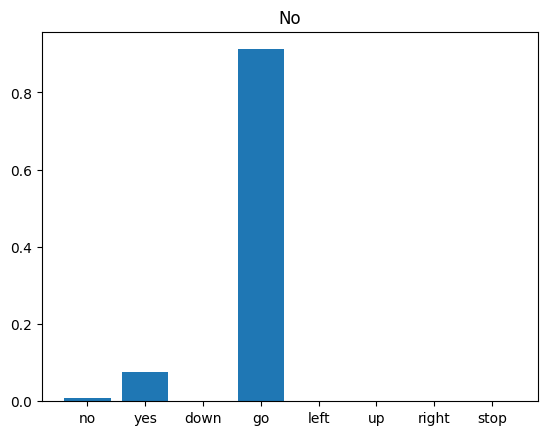

In [ ]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [ ]:
# spectrogram

# resizing

# normalization

# convo1
def convo2_1(input,filter):
  #input (1,32,32,1)
  #output (1,30,30,32)
  batch, height, width, channels = input.shape
  output = np.empty((batch, height - 2, width - 2, 32)) #alustetaan ulostulo muuttuja

  bias = filter[1] #bias arvo saadaan filterin toisesta indexistä


  # 32 pictures * 64 filters * 9 parameters = 18,432
  # jokaiselle kuvalle omat suodattimet
  # bias lisääminen
  for filters in range(32):  # output channel/pictures/filters 32
    for i in range(height - 2):
      for j in range(width - 2):
        for in_channel in range(1):# input channel/ input pictures 1

          convolution_result = np.sum(input[0, i:i + 3, j:j + 3, :] * filter[0][:, :, :, filters]) #kerrotaan filterillä

          output[0, i, j, filters] = convolution_result + bias[filters] # lisätään bias arvo

          # remove negative values
          output[0, i, j, filters] = max(0, output[0, i, j, filters])

  print("oma convo2_2 output shape = ", output.shape)
  output = tf.convert_to_tensor(output, dtype=tf.float32)



  return output



# convo2
def convo2_2(input,filter): #input pictures and filters from the model
  #input shape = (1,30,30,32)
  #filter/kernel shape =  (3, 3, 32, 64)
  #output shape = (1,28,28,64)
  batch, height, width, channels = input.shape
  output = np.empty((batch, height - 2, width - 2, 64)) #alustetaan ulostulo muuttuja

  bias = filter[1] #bias arvo saadaan filterin toisesta indexistä


  # 32 pictures * 64 filters * 9 parameters = 18,432
  # jokaiselle kuvalle omat suodattimet
  # bias lisääminen
  for filters in range(64):  # output channel/pictures 64
    for in_channel in range(32):# input channel/ input pictures 32
     for i in range(height - 2):
      for j in range(width - 2):
          convolution_result = np.sum(input[0, i:i + 3, j:j + 3, :] * filter[0][:, :, :, filters]) #kerrotaan filterillä

          output[0, i, j, filters] = convolution_result + bias[filters] # lisätään bias arvo

          # remove negative values
          output[0, i, j, filters] = max(0, output[0, i, j, filters])

  print("oma convo2_2 output shape = ", output.shape)
  output = tf.convert_to_tensor(output, dtype=tf.float32)
  return output





def max_pooling2d(poolingInput):
  # input = .shape = (1,28,28,64)
  # convert input tensor to a NumPy array
  poolingInput = poolingInput.numpy()

  batch, height, width, channels = poolingInput.shape
  poolingOutput = np.zeros((batch, height // 2, width // 2, channels))

  for b in range(batch):
    for c in range(channels):
      for i in range(0, height, 2):
        for j in range(0, width, 2):
             # Get the 2x2 patch and compute the max
           poolingOutput[b, i // 2, j // 2, c] = np.max(poolingInput[b, i:i + 2, j:j + 2, c])

    # convert the output back to a tensor
  poolingOutput = tf.convert_to_tensor(poolingOutput, dtype=tf.float32)
  print(poolingOutput.shape)
  return poolingOutput





# flatten
# max pooling output lyödään tänne
def flatten(flatInput):
  #input = maxpool2d
  flatOutput = tf.reshape(flatInput,-1) # output = (12544,)
  flatOutput = flatOutput[tf.newaxis,...] # output = (1, 12544)
  print("flatten output.shape = ",flatOutput.shape)
  return flatOutput


# dense1
def dense1(input):
  #dense mallissa
  #input muutetaan tensorista numpyn käyttämään muotoon
  #input = input.numpy()

  weights = get_layer_weights("dense",model)
  weights = weights[0]
  bias = weights[1]

  print("weights = ",weights.shape)
  print("bias = ",bias.shape)


  #alustetaan tulos
  output = np.zeros(weights.shape[1])
  for i in range(weights.shape[1]):  #painojen perusteelta luku
    for j in range(weights.shape[0]): #input luku painojen mukaan
      output[i] = output[i] + input[0,j] * weights[j,i]
    output[i] = output[i] + bias[i]
    #apply RELU
    output[i] = max(0,output[i])
  output = tf.convert_to_tensor(output, dtype=tf.float32)
  output = output[tf.newaxis,...]
  print("oma dense output shape = ", output.shape)
  return output


def dense22(input):
  w,b = get_layer_weights("dense_1",model)
  return tf.matmul(input,w) + b



# dense2
def dense2(input):
  #dense_1 mallissa
  #input muutetaan tensorista numpyn käyttämään muotoon
  input = input.numpy()

  weights = get_layer_weights("dense_1",model)
  weights = weights[0]
  bias = weights[1]

  print("input = ",input.shape)
  print("weights = ",weights.shape)
  print("bias = ",bias.shape)
  #alustetaan tulos
  output = np.zeros(weights.shape[1]) #output = bias koko = 8
  for i in range(0,8,1):  #bias = 8
    for j in range(0,128,1): #weights = 128
      output[i] = output[i] + input[0,j] * weights[j,i]
    output[i] = output[i] + bias[i]
  #output = tf.convert_to_tensor(output, dtype=tf.float32)
  #output = output[tf.newaxis,...]
  print("oma dense_1 output shape = ", output.shape)
  return output



In [ ]:
#convo2_1 testi

(start, layer, end) = get_reference_layer("conv2d", model)
result = start(x)
layer_result = layer(result)
input = result

#filter kernel taken from the model
# apply filters to own function
kernel = get_layer_weights("conv2d",model)
#print("kernel shape = ", kernel.shape)


convoOutput = convo2_1(input,kernel)
print("oma convo2 arvo = ",np.sum(convoOutput))
print("convo2_1 erotus = ", np.sum(np.abs(layer_result)) - np.sum(np.abs(convoOutput)))

oma convo2_2 output shape =  (1, 30, 30, 32)
oma convo2 arvo =  932.7254
convo2_2 erotus =  0.0


In [ ]:
#convo2_2 testi
(start, layer, end) = get_reference_layer("conv2d_1", model)
result = start(x)
layer_result = layer(result)
input = result

#filter kernel taken from the model
# apply filters to own function
kernel = get_layer_weights("conv2d_1",model)
#print("kernel values = ", kernel.shape)


convoOutput = convo2_2(input,kernel)
print("oma convo2 arvo = ",np.sum(convoOutput))
print("convo2_2 erotus = ", np.sum(np.abs(layer_result)) - np.sum(np.abs(convoOutput)))


oma convo2_2 output shape =  (1, 28, 28, 64)
oma convo2 arvo =  354.6494
convo2_2 erotus =  0.0


In [ ]:
#viimeinen dense
#laskee väärin ???
(start, layer, end) = get_reference_layer("dense_1", model)
result = start(x)
layer_result = layer(result)
input = result

erotus = np.sum(np.abs(layer_result)) - np.sum((np.abs(dense2(input))))
print("layer_result = ", np.sum(np.abs(layer_result)))
print("dense2 = ", np.sum(np.abs(dense2(input))))
print("erotus = ",erotus)


input =  (1, 128)
weights =  (128, 8)
bias =  (8,)
oma dense_1 output shape =  (8,)
layer_result =  21.37192
input =  (1, 128)
weights =  (128, 8)
bias =  (8,)
oma dense_1 output shape =  (8,)
dense2 =  20.933081982234853
erotus =  0.43883764972315475


In [ ]:
#convo_1 testi
(start, layer, end) = get_reference_layer("conv2d", model)
result = start(x)
layer_result = layer(result)
input = result

kernel = get_layer_weights("conv2d",model)

convoOutput1 = convo2_1(input,kernel)
print("oma convo2 arvo = ",np.sum(convoOutput1))
print("convo2_1 erotus = ", np.sum(np.abs(layer_result)) - np.sum(np.abs(convoOutput1)))

#convo_2 testi
(start, layer, end) = get_reference_layer("conv2d_1", model)
result = start(x)
layer_result = layer(result)
input = result

convoOutput = convo2_2(convoOutput1,get_layer_weights("conv2d_1",model))
print("oma convo2 arvo = ",np.sum(convoOutput))
print("convo2_2 erotus = ", np.sum(np.abs(layer_result)) - np.sum(np.abs(convoOutput)))
# maxpool testi

(start, layer, end) = get_reference_layer("max_pooling2d", model)
result = start(x)
layer_result = layer(result)
input = result

maxpoolresult = max_pooling2d(convoOutput)

erotus = np.sum(np.abs(layer_result)) - np.sum(np.abs(max_pooling2d(convoOutput)))
print("maxpooling erotus = ",erotus)


#flatten testi

(start, layer, end) = get_reference_layer("flatten", model)
result = start(x)
layer_result = layer(result)
flattenout = flatten(maxpoolresult)
erotus = np.sum(np.abs(layer_result)) - np.sum(np.abs(flattenout))
print("flatten erotus = ",erotus)

#ensimmäinen dense
(start, layer, end) = get_reference_layer("dense", model)
result = start(x)
layer_result = layer(result)
input = result

dense22out = dense22(flattenout)

erotus = np.sum(np.abs(layer_result)) - np.sum(np.abs(dense22out))
print("dense22 erotus = ", erotus)
#erotus = np.sum(np.abs(layer_result)) - np.sum(np.abs(dense1(test)))
#print("erotus = ",erotus)

#viimeinen dense
(start, layer, end) = get_reference_layer("dense_1", model)
result = start(x)
layer_result = layer(result)
input = result

erotus = np.sum(np.abs(layer_result)) - np.sum(np.abs(dense2(dense22out)))
print("erotus = ",erotus)

oma convo2_2 output shape =  (1, 30, 30, 32)
oma convo2 arvo =  932.7254
convo2_1 erotus =  0.0
oma convo2_2 output shape =  (1, 28, 28, 64)
oma convo2 arvo =  354.64935
convo2_2 erotus =  6.1035156e-05
(1, 14, 14, 64)
(1, 14, 14, 64)
maxpooling erotus =  1.5258789e-05
flatten output.shape =  (1, 12544)
flatten erotus =  1.5258789e-05


InvalidArgumentError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Matrix size-incompatible: In[0]: [1,12544], In[1]: [128,8] [Op:MatMul] name: 

In [ ]:
'''
Homma kannattaisi aloittaa verkon loppupäästä

'''



#dense testi
(start, layer, end) = get_reference_layer("dense", model)
weights = get_layer_weights("dense",model)

#print(weights[0].shape)
#print(weights[1].shape)
result = start(x)
layer_result = layer(result)
input = result

weights = weights[0]
bias = weights[1]
#layer_oma_result0 = dense2(input,weights,bias)
#print("oma tulos = ",layer_oma_result0)

(start, layer, end) = get_reference_layer("dense_1", model)




# To use the model parts, call the part with the input data
result = start(x)             # tämä antaa siis verkon oikean tuloksen ennen viimeistä dense_65
                              # layeriä
layer_result = layer(result)  # Ja tämä tuloksen dense_65:n jälkeen
input = result                   # viimeiseen neuroverkon kerrokseen menevät 128 neuronia inputtina


layer_oma_result = dense2(input)
#print("oma tulos = ",layer_oma_result)

#print(layer_result)
print("mallin dense layer shape = ",layer_result.shape)
#print(layer_result[0,:])
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.figure(1)
plt.subplot(1,2,1)
plt.bar(x_labels, tf.nn.softmax(layer_result[0,:]))
plt.subplot(1,2,2)
plt.bar(x_labels, tf.nn.softmax(layer_oma_result))

#plt.title('No')
plt.show()